# Assignment 1: k-nearest neighbors

Only use the already imported libraries `numpy` and `matplotlib.pyplot` for the assignment. Do not import any other library. 

In [1]:
# Load required packages and dataset. Do not modify.import TODO as TODO
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()


## Task 1: Visualization and Preprocessing

1) Explain the content of the dataset in few words. What are the input features? What is the classification target? Check out: [https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set).


This dataset contains data of morphologic variations in Iris flowers. It has 4 input features (sepal length, sepal width, petal length, and petal width) and 3 classification targets which denote the corresponding type of Iris flowers: Iris setosa, Iris virginica, and Iris versicolor.

2) Compute and print the following statistics about the dataset:
  - Number of samples
  - Number of samples per class
  - Mean and standard deviation for each input feature


In [2]:
# Print the number of samples in the dataset
n_samples, n_features = X.shape
print("Number of samples:", n_samples)
print("Number of features:", n_features)

# Class distribution
print("Samples per class:")
index, samples_count = np.unique(y, return_counts=True)
samples_per_class = dict(zip(index, samples_count))
for index in samples_per_class:
    print('{:>5}'.format(''), index, ' : ', samples_per_class[index])

# Finding the mean and standard deviation of each feature
f_mean = (np.mean(X, axis=0))
f_std = (np.std(X, axis=0))
print("Mean and standard deviation of each feature: ")
print("{:>5}Sepal-length:".format(''), "%.4f" % f_mean[0], ", %.4f" % f_std[0])
print("{:>5}Sepal-width:".format(''), "%.4f" % f_mean[1], ", %.4f" % f_std[1])
print("{:>5}Petal-length:".format(''), "%.4f" % f_mean[2], ", %.4f" % f_std[2])
print("{:>5}Petal-width:".format(''), "%.4f" % f_mean[3], ", %.4f" %f_std[3])

Number of samples: 150
Number of features: 4
Samples per class:
      0  :  50
      1  :  50
      2  :  50
Mean and standard deviation of each feature: 
     Sepal-length: 5.8433 , 0.8253
     Sepal-width: 3.0573 , 0.4344
     Petal-length: 3.7580 , 1.7594
     Petal-width: 1.1993 , 0.7597


3) Visualize the variables Sepal length and Petal length in a scatter plot (Sepal length on the x-axis, petal length on the y-axis). Color each point of the plot according to its class.

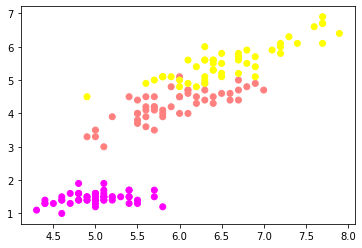

In [3]:
# Plot Sepal-length (x) and Petal-length (y) data to a scatter plot
plt.scatter(X[:,0], X[:,2], c=y, cmap=plt.cm.spring) # Colour according to class
plt.show()

4) Split the dataset randomly into training and test data. 70% of data should be used for training and 30% should be used for testing. Implement the function `train_test_split`. Do not modify the interface of the function.

In [4]:
def train_test_split(X, y):
    """
    Returns X_train, X_test, y_train, y_test, 
        where X_train and X_test are the input features of the training and test set,
        and y_train and y_test are the class labels of the training and test set.
    """
    # samling evenly with regard to TRAIN_SET_RATIO
    # 70% for training and 30% for test
    TRAIN_SET_RATIO = 0.7
    TEST_SET_RATIO = 1 - TRAIN_SET_RATIO

    # if the input data is random, just take the continuous portion
    # otherwise, in a ordered data sampling is required to guarantee training set have all the data
    is_random = False

    if is_random:
        nx_split = int(TRAIN_SET_RATIO * X.shape[0])
        ny_split = int(TRAIN_SET_RATIO * y.shape[0])
        X_train = X[:nx_split]
        X_test = X[nx_split:]
        y_train = y[:ny_split]
        y_test = y[ny_split:]
    else:
        index_class, class_counts = np.unique(y, return_counts=True)
        samples_class = dict(zip(index_class, samples_count))
        samples = int(samples_class[0]*TRAIN_SET_RATIO)
        X_train = X[: samples]
        X_test = X[samples : samples_class[0]]
        y_train = y[: samples]
        y_test = y[samples : samples_class[0]]
        pos = int(0)
        for index in samples_class:
            samples = int(samples_class[index]*TRAIN_SET_RATIO)
            num = int(samples_class[index])
            if index != 0:
                X_train = np.concatenate((X_train, X[pos : pos + samples]), axis=0)
                X_test = np.concatenate((X_test, X[pos + samples : pos + num]), axis=0)
                y_train = np.concatenate((y_train, y[pos : samples + pos]), axis=0)
                y_test = np.concatenate((y_test, y[pos +samples : pos + num]), axis=0)
            pos = pos + num

    # Slicing the 2D arrays
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0]
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]
assert X_train.shape[1] == X_test.shape[1]


5) kNN uses a distance measure to identify close neighbors. If the input features are not of the same scale, the distance is not as meaningful, which can negatively impact classification performance. Perform min-max scaling (i.e. scale the values of the input features in such a way that their range is from 0 to 1) on the training and test data. Remember that you should only use information from the training data to perform the scaling on both data sets.

In [5]:
# Min-max rescaling of training data values
vmin = X_train.min(axis=0) # Find min values of each feature
vmax = X_train.max(axis=0) # Find max values of each feature

for i in range(4):
    X_train[:,i] = (X_train[:,i] - vmin[i]) / (vmax[i] - vmin[i])

# Now rescale test data
for i in range(4):
    X_test[:,i] = (X_test[:,i] - vmin[i]) / (vmax[i] - vmin[i])
# print(X_train)
# print(X_test)

## Task 2: k-nearest neighbors

**For B.Sc. Data Science:**  
Implement the kNN algorithm with uniform weighting and arbitrary `k`. Fill out the `predict` method of class `KNearestNeighborsClassifier`. 

Use Euclidean distance to determine the nearest neighbors.
You can ignore the optional parameter `distance_metric`, which is provided as a field in the kNN class.

**For everyone else:**  
Implement the kNN algorithm with distance-based weighting and arbitrary `k`.
Fill out the `predict` method of class `KNearestNeighborsClassifier`.

The parameter `distance_metric` will either contain the string `uniform` or a function. If the value is `uniform`, the classifier should use the Euclidean distance for determining nearest neighbors and uniform weighting. If the value is a function, the classifier should use the function as distance metric and perform distance-weighted classification. An example distance metric is provided with `euclidean_distance`.

In [6]:
class KNearestNeighbors(object):
    # distance_metric : {‘uniform’, ‘euclidean’}, optional 
    # This is optional and the default is 'uniform'
    def __init__(self, k, distance_metric='uniform'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X, y):
        """
        This functions saves the training data to be used during the prediction.
        """
        self.X = X
        self.y = y

    def predict(self, X):
        """
        Returns a vector of shape (n,) if X has shape (n,k).
        """
        n, k = X.shape
        Y = X
        ans = np.array([0 for col in range(n)])
        for i in range(n):
            find_neighbor = [(0.0,0) for col in range(self.X.shape[0])]
            for j in range(self.X.shape[0]):
                dist = 0.0
                if self.distance_metric == 'euclidean':
                    dist = euclidean_distance(Y[i], self.X[j])
                else:
                    dist = uniform_distance(Y[i], self.X[j])
                find_neighbor[j] = (dist, self.y[j])
            find_neighbor.sort()
            catagory = {}
            for j in range(self.k):
                if find_neighbor[j][1] in catagory:
                    catagory[find_neighbor[j][1]] += 1
                else:
                    catagory[find_neighbor[j][1]] = 1
            max_key = 0
            max_value = 0
            for j, l in catagory.items():
                if l > max_value:
                    max_key = j
                    max_value = k
            ans[i] = max_key
        return ans

def uniform_distance(x1, x2):
    return np.amax(np.absolute(x1 - x2))
    
def euclidean_distance(x1, x2):
    """
    Given vectors x1 and x2 with shape (n,) returns distance between vectors as float.
    """
    return np.sqrt(np.sum((x1 - x2)*(x1 - x2)))

# testing for class
myKNN = KNearestNeighbors(1)
myKNN.fit(X_train, y_train)
y_pred = myKNN.predict(X_train)
assert np.array_equal(y_pred, y_train)

## Task 3: Evaluation

1) Implement functions to compute precision, recall and F1-score. `y_pred` and `y_true` are the vectors of predicted and true class labels respectively with shape `(n,)`, where `n` is the number of samples. Each function should return a float containing the corresponding score.

In [8]:
def precision(y_pred, y_true):
    # Implement your solution here.
    assert len(y_pred) == len(y_true), "Predict and True size not match"                        

    # y_true suppose containing all classification types
    # returning an 1d array with precision for each types

    # sample_per_classe is a dict for indicated number of count for each types
    types, type_counts = np.unique(y_true, return_counts=True)

    y_precision = np.zeros(len(types), dtype=float)
    
    for type_index in range(len(types)):
        temp = np.zeros(len(types), dtype=float)
        for y_index in range(len(y_true)):
            if y_true[y_index] == types[type_index]:
                temp[y_true[y_index]] += 1
        y_precision[type_index] = temp[type_index] / np.sum(temp)
    print("Precision: ", y_precision)
    return y_precision

def recall(y_pred, y_true):
    # Implement your solution here.
    assert len(y_pred) == len(y_true), "Predict and True size not match"                        
    types, type_counts = np.unique(y_true, return_counts=True)
    temp = np.zeros(len(types), dtype=float)
    y_recall = np.zeros(len(types), dtype=float)
    
    for type_index in range(len(types)):
        temp = np.zeros(len(types), dtype=float)
        for y_index in range(len(y_true)):
            if y_true[y_index] == types[type_index]:
                temp[y_pred[y_index]] += 1
        y_recall[type_index] = temp[type_index] / np.sum(temp)
    print("Recall: ",y_recall)
    return y_recall

def f1score(y_pred, y_true):
    # Implement your solution here.
    y_precision = precision(y_pred, y_true)  
    y_recall = recall(y_pred, y_true)
    assert (len(y_precision) == len(y_recall)), "Precision and Recall size not match"
    y_f1score = np.zeros(len(y_recall), dtype=float)  
    for index in range(len(y_f1)):
        y_f1score[index] = 2 * y_precision[index] * y_recall[index] / (y_precision[index] + y_recall[index])
    print("f1 score: ",y_f1score)
    return y_f1score                        

def test_recall(y_pred, y_true):                         
    y_recall = recall(y_true, y_true)
    y_precision= precision(y_true, y_true)
    all_ones = np.ones(len(y_recall), dtype=float);
    assert np.array_equal(all_ones, y_recall), "recall() implement error, Recall should all be 1"
    assert np.array_equal(all_ones, y_precision), "precision() implement error, Recall should all be 1"
    pass
                             
test_recall(y_pred_train, y_train)

Recall:  [1.         0.5        0.33333333]
Precision:  [1.         0.5        0.33333333]


AssertionError: recall() implement error, Recall should all be 1

2) Evaluate the performance of kNN with uniform weighting on the Iris dataset for `k=1,3,5`. Train each of the `3` classifiers on the training data from Task 1. Perform the predictions on both the training and test data. Then compute precision, recall, and F1-score for each model and for both training and test data. Print all scores per model. What do you observe?

**For all students other than B.Sc. Data Science:** 
Evaluate the kNN classifier with Euclidean distance-weighting. Compare the performance to uniform-weighting. How does the performance change compared to uniform weighting for each `k`?

In [ ]:
# Implement your solution here.

==> *Write your observations here and report your results.* (double klick here to edit)

3) Explain why kNN with `k=1` achieves perfect results on the training data. Why is it not the best model?

==> *Write your response here.* (double klick here to edit)